In [61]:
import json
import matplotlib.pyplot as plt
import numpy as np
import itertools
import glob
plt.style.use('ggplot')
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

In [62]:
# Verified using |axb| = |a||b|sin(θ)
def dca(point_prim, point_sec, momentum):
    d = np.cross(point_prim - point_sec, momentum)
    return np.linalg.norm(d) / np.linalg.norm(momentum)

In [63]:
p1 = np.array([0, 0, 0])
p2 = np.array([0, 2, 0])
m = np.array([2, 0, 0])
m = np.array([0, 2, 0])

In [39]:
dca(p1, p2, m)

np.float64(0.0)

In [65]:
def process(file):
    try:
        with open(file, 'rb') as f:
            data = json.load(f)
            event_dcas = []
            for event in data['Events']:
                ip = np.array(event['MetaData']['CollisionVertex'])
                dcas = []
                for track in event['TruthHit']['TruthTracks']:
                    momentum = np.array(track['TrackMomentum'])
                    sv = np.array(track['OriginVertexPoint'])
                    dcas.append(dca(ip, sv, momentum))
                if len(dcas) > 0:
                    event_dcas.append(np.array(dcas))
            return event_dcas
    except Exception:
        return np.array([[]])

def process_aggregate(file, aggregate=max):
    try:
        with open(file, 'rb') as f:
            data = json.load(f)
            event_dcas = []
            for event in data['Events']:
                ip = np.array(event['MetaData']['CollisionVertex'])
                dcas = []
                for track in event['TruthHit']['TruthTracks']:
                    momentum = np.array(track['TrackMomentum'])
                    sv = np.array(track['OriginVertexPoint'])
                    dcas.append(dca(ip, sv, momentum))
                if len(dcas) > 0:
                    event_dcas.append(aggregate(dcas))
            return event_dcas
    except Exception:
        return np.array([])

In [66]:
N_FILES = 100

In [67]:
signal_dcas = Parallel(n_jobs=16)(delayed(process)(file) for file in  tqdm(glob.glob('/disks/disk1/tingtingxuan/HFMLNewFiles-old/Signal/*')[:N_FILES]))

  0%|          | 0/100 [00:00<?, ?it/s]

In [68]:
background_dcas = Parallel(n_jobs=16)(delayed(process)(file) for file in  tqdm(glob.glob('/disks/disk1/tingtingxuan/HFMLNewFiles-old/Background/*')[:N_FILES]))

  0%|          | 0/100 [00:00<?, ?it/s]

In [69]:
signal_dcas_a = Parallel(n_jobs=16)(delayed(process_aggregate)(file) for file in  tqdm(glob.glob('/disks/disk1/tingtingxuan/HFMLNewFiles-old/Signal/*')[:N_FILES]))

  0%|          | 0/100 [00:00<?, ?it/s]

In [70]:
background_dcas_a = Parallel(n_jobs=16)(delayed(process_aggregate)(file) for file in  tqdm(glob.glob('/disks/disk1/tingtingxuan/HFMLNewFiles-old/Background/*')[:N_FILES]))

  0%|          | 0/100 [00:00<?, ?it/s]

In [71]:
signal_dcas_a = np.concatenate(signal_dcas_a, axis=0)
background_dcas_a = np.concatenate(background_dcas_a, axis=0)

Text(0.5, 1.0, 'Full Distribution')

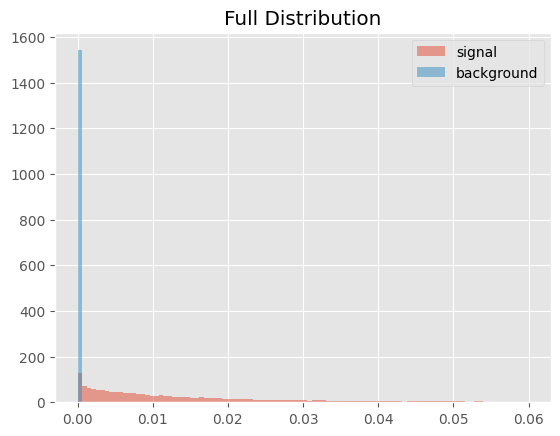

In [84]:

plt.hist(signal_dcas_a[signal_dcas_a < 0.06], label='signal', alpha=0.5, bins=100, density=True)
plt.hist(background_dcas_a[background_dcas_a < 0.06], label='background', alpha=0.5, bins=100, density=True)
#plt.xlim(0, 0.06)
plt.legend()
#plt.yscale('log')
plt.title('Full Distribution')

1. Draw DCA distribution of pion-kaon and draw the DCA the distribution from non pion-kaon tracks
2. We should see two "humps" over all the tracks.
3. Draw DCA distribution of signal kaon-pion tracks and background tracks

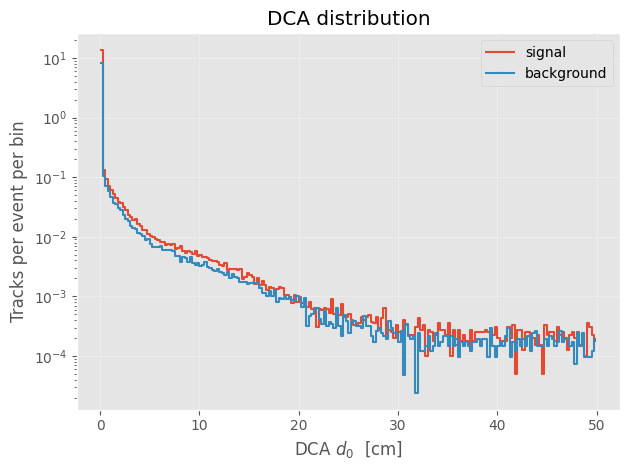

In [77]:
bins        = np.linspace(0, 50, 201)              
hist_global = np.zeros(len(bins) - 1, dtype=np.int64) 
n_events    = 0

for file_events in signal_dcas:        
    for dcas_this_event in file_events:  
        # dcas_this_event is a 1-D array or list of per-track DCAs
        hist_global += np.histogram(dcas_this_event, bins=bins)[0]
        n_events    += 1                
hist_per_event = hist_global / n_events

# quick plot
centres = 0.5 * (bins[1:] + bins[:-1])
plt.step(centres, hist_per_event, where="mid", label='signal')
plt.xlabel(r"DCA $d_0$  [cm]")
plt.ylabel("Tracks per event per bin")
plt.title(f"DCA distribution")
plt.yscale('log')

# define your global binning once
hist_global = np.zeros(len(bins) - 1, dtype=np.int64)    # accumulator
n_events    = 0

for file_events in background_dcas:        
    for dcas_this_event in file_events:
        # dcas_this_event is a 1-D array or list of per-track DCAs
        hist_global += np.histogram(dcas_this_event, bins=bins)[0]
        n_events    += 1                
hist_per_event = hist_global / n_events

# quick plot
centres = 0.5 * (bins[1:] + bins[:-1])
plt.step(centres, hist_per_event, where="mid", label='background')
plt.grid(alpha=0.3);  plt.tight_layout();  plt.legend()


1. Need to plot the DCA *per track*. In a typical physics collision, you have one heavy-flavor decay and the other particles have their own DCA distribution. Do NOT perform the average, need to look at the DCA track-by-track
2. Seperate tracks based on signal tracks vs background. For signal events, a few tracks have a LARGE DCA if they are from heavy-flavor decay. Some non-heavy quark decay particles have large DCA.
3. DCA can be measured in two ways. The first way is to find the distance of closest approach from the track to the primary vertex. Dantong suggests difference between secondary vertex and primary vertex.
4. Momentum information is given where? Secondary vertex
5. Monte-Carlo tracks have the "true momentum". Depends on how it was saved, but I will assume it is saved at the secondary vertex
6. For the real data, p_x, p_y, p_z are poorly defined. Normally, we assume the tracks start at the primary vertex, and calculate the momentum vector *at* the primary vertex, even though that might not be accurate
7. However, for tracks that we think don't originate from the primary vertex, we re-fit the momentum to the secondary vertex. However, *WE ARE NOT IN THAT STAGE YET*. However, the fact that we have "TrackPosition" indicates that the fitting was not done forcing the track to go through the secondary vertex. This means TrackPosition is the reference point for the momentum.
8. Secondary Vertex is *NOT* "Track Position"

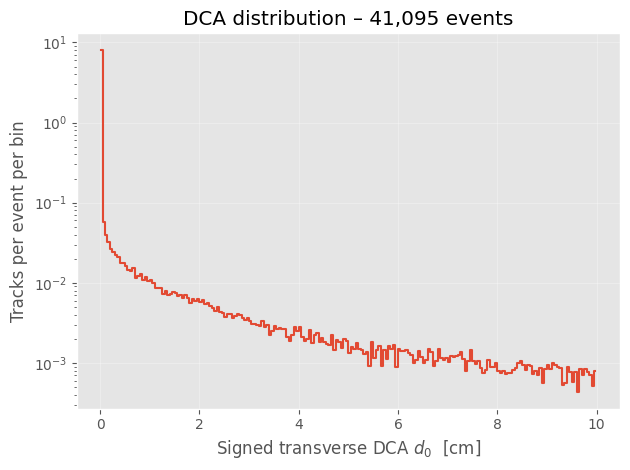

In [68]:

plt.xlabel(r"Signed transverse DCA $d_0$  [cm]")
plt.ylabel("Tracks per event per bin")
plt.title(f"DCA distribution – {n_events:,} events")
plt.yscale('log')
plt.grid(alpha=0.3);  plt.tight_layout();  plt.show()

1. Do the DCA on the K-short

In [ ]:
hist_per_e

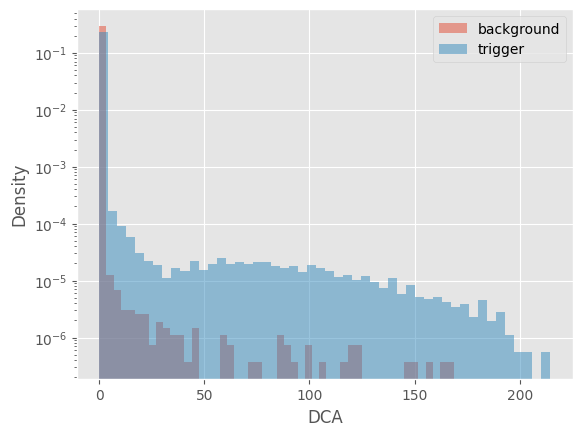

In [45]:
plt.hist(signal_dcas, alpha=0.5, density=True, bins=50, label='background')
plt.hist(background_dcas, alpha=0.5, density=True, bins=50, label='trigger')
plt.xlabel('DCA')
plt.ylabel('Density')
plt.legend()
plt.yscale('log')

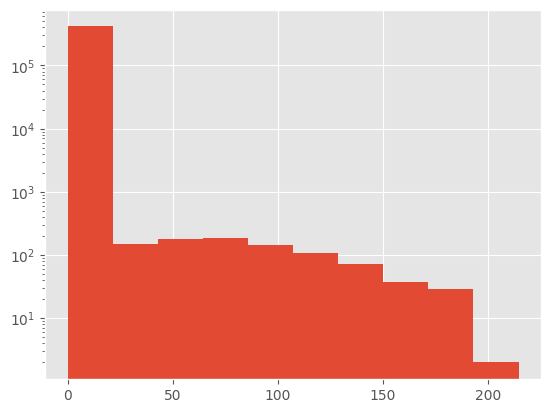

In [37]:
plt.yscale('log')

# NPZ Files

In [16]:
def process_npz(file):
    try:
        with np.load(file) as event:
            ip = event['interaction_point']
            dcas = []
            for i in range(len(event['track_hits'])):
                momentum = event['momentum'][i]
                sv = event['track_origin']
                dcas.append(dca(ip, sv, momentum))
            return np.array(dcas)
    except Exception:
        return np.array([])

In [28]:
def process_npz_filtered(file, selection=False):
    try:
        with np.load(file) as event:
            ip = event['interaction_point']
            dcas = []
            for i in range(len(event['track_hits'])):
                if event['trigger_node'][i] != selection:
                    continue
                momentum = event['momentum'][i]
                sv = event['track_origin']
                dcas.append(dca(ip, sv, momentum))
            return np.array(dcas)
    except Exception:
        return np.array([])

In [27]:
0 == False

True

In [17]:
N_FILES = 50000

In [18]:
signal_dcas = Parallel(n_jobs=16)(delayed(process_npz)(file) for file in  tqdm(glob.glob('/ssd3/giorgian/tracks-data-august-2022/trigger/1/*.npz')[:N_FILES]))

  0%|          | 0/50000 [00:00<?, ?it/s]

In [19]:
background_dcas = Parallel(n_jobs=16)(delayed(process_npz)(file) for file in  tqdm(glob.glob('/ssd3/giorgian/tracks-data-august-2022/nontrigger/0/*.npz')[:N_FILES]))

  0%|          | 0/50000 [00:00<?, ?it/s]

In [20]:
signal_dcas.shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
signal_dcas = np.concatenate(signal_dcas, axis=0)
background_dcas = np.concatenate(background_dcas, axis=0)

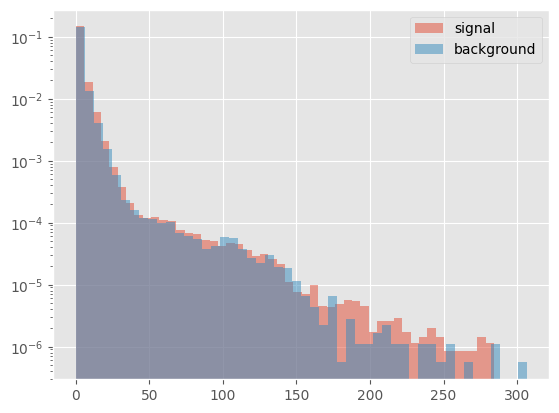

In [26]:

plt.hist(signal_dcas, label='signal', alpha=0.5, density=True, bins=50)
plt.hist(background_dcas, label='background', alpha=0.5, density=True, bins=50)
plt.legend()
plt.yscale('log')

In [24]:
len(signal_dcas), len(background_dcas)

(612332, 294643)

In [29]:
trigger_signal_dcas = Parallel(n_jobs=16)(delayed(lambda file: process_npz_filtered(file, selection=True))(file) for file in  tqdm(glob.glob('/ssd3/giorgian/tracks-data-august-2022/trigger/1/*.npz')[:N_FILES]))

  0%|          | 0/50000 [00:00<?, ?it/s]

In [30]:
nontrigger_signal_dcas = Parallel(n_jobs=16)(delayed(lambda file: process_npz_filtered(file, selection=False))(file) for file in  tqdm(glob.glob('/ssd3/giorgian/tracks-data-august-2022/trigger/1/*.npz')[:N_FILES]))

  0%|          | 0/50000 [00:00<?, ?it/s]

In [31]:
trigger_signal_dcas = np.concatenate(trigger_signal_dcas, axis=0)
nontrigger_signal_dcas = np.concatenate(nontrigger_signal_dcas, axis=0)

Text(0.5, 0, 'DCA')

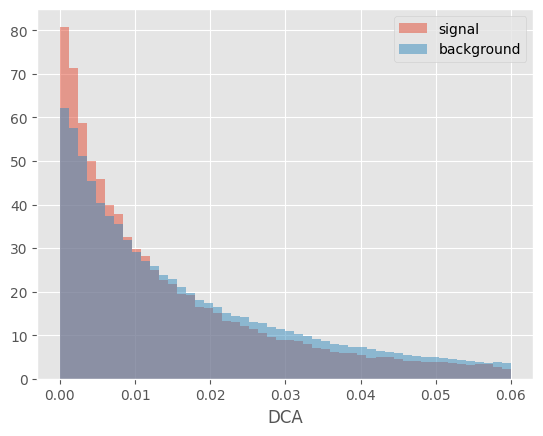

In [86]:

plt.hist(trigger_signal_dcas[trigger_signal_dcas < 0.06], label='signal', alpha=0.5, density=True, bins=50)
plt.hist(nontrigger_signal_dcas[nontrigger_signal_dcas < 0.06], label='background', alpha=0.5, density=True, bins=50)
plt.legend()
plt.xlabel('DCA')

# Beauty Files

In [ ]:
signal_dcas_beauty = Parallel(n_jobs=16)(delayed(process_npz)(file) for file in  tqdm(glob.glob('/ssd3/giorgian/tracks-data-august-2022/trigger/1/*.npz')[:N_FILES]))
signal_dcas_beauty = Parallel(n_jobs=16)(delayed(process_npz)(file) for file in  tqdm(glob.glob('/ssd3/giorgian/tracks-data-august-2022/trigger/1/*.npz')[:N_FILES]))

In [50]:
def process_npz_beauty(file):
    try:
        with np.load(file) as event:
            ip = event['interaction_point']
            dcas = []
            pids = np.unique(event['particle_id'])
            for pid in pids:
                mask = event['particle_id'] == pid
                momentum = event['momentum'][mask][0]
                sv = event['track_origin'][mask][0]
                dcas.append(dca(ip, sv, momentum))
            return np.array(dcas)
    except Exception:
        raise

In [51]:
signal_dcas = Parallel(n_jobs=16)(delayed(process_npz_beauty)(file) for file in  tqdm(glob.glob('/ssd3/giorgian/hits-data-january-2024-yasser/trigger/events/*.npz')[:N_FILES]))

  0%|          | 0/39900 [00:00<?, ?it/s]

In [52]:
background_dcas = Parallel(n_jobs=16)(delayed(process_npz_beauty)(file) for file in  tqdm(glob.glob('/ssd3/giorgian/hits-data-january-2024-yasser/nontrigger/events/*.npz')[:N_FILES]))

  0%|          | 0/34400 [00:00<?, ?it/s]

In [57]:
signal_dcas.shape

(943900,)

In [55]:
signal_dcas = np.concatenate(signal_dcas, axis=0)
background_dcas = np.concatenate(background_dcas, axis=0)

ValueError: zero-dimensional arrays cannot be concatenated

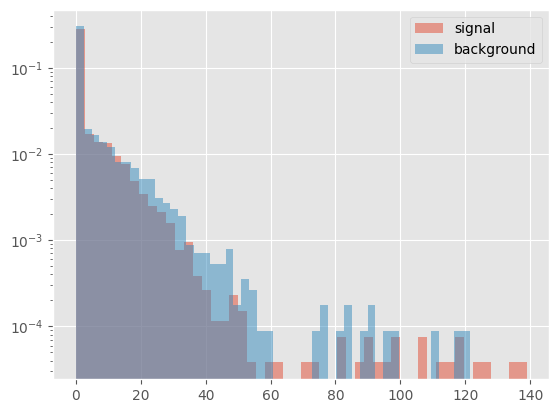

In [58]:


plt.hist(signal_dcas, label='signal', alpha=0.5, density=True, bins=50)
plt.hist(background_dcas, label='background', alpha=0.5, density=True, bins=50)
plt.legend()
plt.yscale('log')

# Real Data

In [107]:
def process_npz_real(file):
    try:
        with np.load(file) as event:
            ip = event['interaction_point']
            dcas = []
            for i in range(event['momentum'].shape[0]):
                momentum = event['momentum'][i]
                sv = event['track_origin'][i]
                dcas.append(dca(ip, sv, momentum))
            return np.array(dcas)
    except Exception:
        raise

In [108]:
signal_dcas = Parallel(n_jobs=16)(delayed(process_npz_real)(file) for file in  tqdm(glob.glob('/home1/giorgian/real-data/parsed-tracks/trigger/events/*.npz')[:N_FILES]))

  0%|          | 0/73 [00:00<?, ?it/s]

In [ ]:
backgrounddcas = Parallel(n_jobs=16)(delayed(process_npz_real)(file) for file in  tqdm(glob.glob('/home1/giorgian/real-data/parsed-tracks/trigger/events/*.npz')[:N_FILES]))

In [99]:
files = !ls ~/real-data/parsed-tracks/trigger/events/*.npz

In [100]:
f = np.load(files[0])

In [104]:
f['momentum'].shape, f['track_origin'].shape

((9, 3), (9, 3))

In [118]:
signal_dcas_a = np.concatenate(signal_dcas, axis=0)
background_dcas_a = np.concatenate(background_dcas, axis=0)

Text(0.5, 1.0, 'Full Distribution')

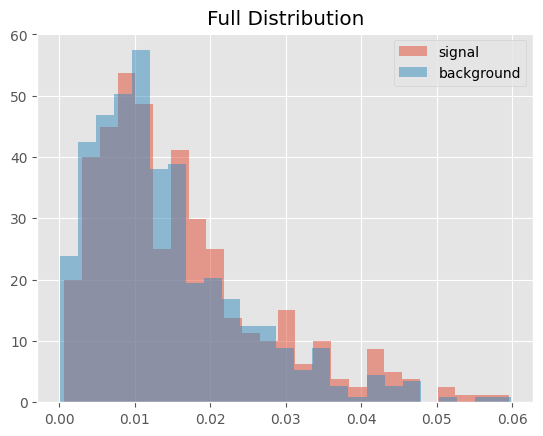

In [119]:
plt.hist(signal_dcas_a[signal_dcas_a < 0.06], label='signal', alpha=0.5, bins=25, density=True)
plt.hist(background_dcas_a[background_dcas_a < 0.06], label='background', alpha=0.5, bins=25, density=True)
#plt.xlim(0, 0.06)
plt.legend()
#plt.yscale('log')
plt.title('Full Distribution')

In [121]:
signal_dcas_a = np.array(list(map(max, signal_dcas)))
background_dcas_a = np.array(list(map(max, background_dcas)))

Text(0.5, 1.0, 'Full Distribution')

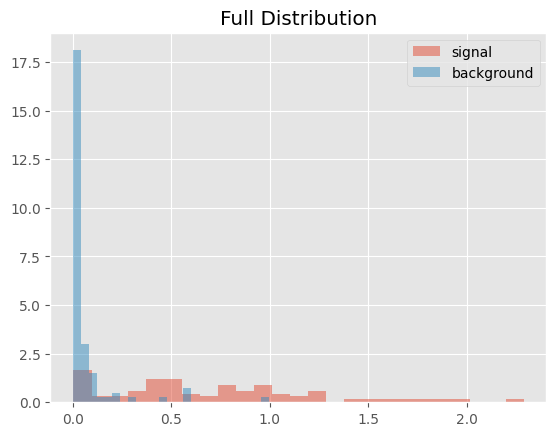

In [123]:
plt.hist(signal_dcas_a[signal_dcas_a < 500 ], label='signal', alpha=0.5, bins=25, density=True)
plt.hist(background_dcas_a[background_dcas_a < 500], label='background', alpha=0.5, bins=25, density=True)
#plt.xlim(0, 0.06)
plt.legend()
#plt.yscale('log')
plt.title('Full Distribution')